<a href="https://colab.research.google.com/github/CarlosSMWolff/ParamEst-NN/blob/main/notebooks/3-Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Results

##  Goal

In this notebook we provide codes to reproduce the main results in the article, which includes the validation of the trained models and benchmarking against Bayesian inference protocols.

## Imports

In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from numpy import sqrt 
from random import * 
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
import pickle


## Setup and Requirements

### Colab setup

If this notebook is run online in Google Colab, we:
- Download the repository from GitHub.
- Install the custom pacakge

In [3]:
# Find out if this notebook is running in Google Colab
isColab= 'google.colab' in str(get_ipython())

# Download repository if we are in Colab and install "paramest_nn" package
if isColab:
  print('We are running in Colab. Cloning repository.')
  # Download the repository (necessary to access functions in /src folder)
  ! git clone https://github.com/CarlosSMWolff/ParamEst-NN

  print('Repository downloaded.')
  ! mv ParamEst-NN/* . && rm -r ParamEst-NN

  print('Installing paramest_nn package')
  ! pip install -e .

### Import custom packages + Qutip

In [4]:
from paramest_nn.quantum_tools import *
from qutip import *

### Define data path

In [5]:
# specify the data path
datapath = '../data/'

# if running in Colab, remove the "../"
if isColab:
    datapath = datapath.split("../")[1]

Create data folder in the datapath if not already present

In [6]:
create_directory(datapath)

Folder already exists.


### Populate data folder with required data

This notebook requires the following populated folders

- `[datapath]/validation-trajectories/`
- `[datapath]/models/`
- `[datapath]/results_cache/bayesian_estimation/2D/estimationBayes2DUltranest`

#### Option #1: Downloading the data

The data that was used for the results shown in the paper can be downloaded from [Zenodo](https://zenodo.org/).
You can choose to download this data automatically by setting

 ```python
 download_required = True
 ```
 
  in the following cell. 
This will be done automatically if this notebook is run in Google Colab.


In [7]:
download_required = False

if isColab:
    download_required = True

##### Download links (Mirror 1 - Dropbox)

In [8]:
url_download_validation_trajs = "https://www.dropbox.com/scl/fi/rvpg0lmyxoqt94qu510ws/validation-trajectories.zip?rlkey=3xhp5nh4ul5ekn43xchszrqu5&dl=0"
url_download_models = "https://www.dropbox.com/scl/fi/3u8scm7vq22s9qvb1b0jo/models.zip?rlkey=qn2xtzjjwx5x57caokxbjexj5&dl=0"
url_download_results_cache = "https://www.dropbox.com/scl/fi/s31ijcmv1a7iu61y8c4sa/results_cache.zip?rlkey=o7jhr98mpzjo1vmtp4q1e06m6&dl=0"

##### Download links (Mirror 2 - Zotero)

Uncomment the following cell if the Dropbox links in Mirror 1 are not operative. 

Hosting of this data in Zenodo is guaranteed, although download times might be slower

In [9]:
# url_download_validation_trajs = "https://zenodo.org/record/8305509/files/validation-trajectories.zip?download=1"
# url_download_models = "https://zenodo.org/record/8305509/files/models.zip?download=1"
# url_download_results_cache = "https://zenodo.org/record/8305509/files/results_cache.zip?download=1"

##### Download data
You may want to go and grab a coffee ☕️

In [10]:
if download_required == True:
    ! wget -q -O validation-trajectories.zip --show-progress "$url_download_validation_trajs" && unzip -q validation-trajectories.zip -d "$datapath" &&  rm validation-trajectories.zip
    ! wget -q -O models.zip --show-progress "$url_download_models" && unzip -q models.zip -d "$datapath" &&  rm models.zip
    ! wget -q -O results_cache.zip --show-progress "$url_download_results_cache" && unzip -q results_cache.zip -d "$datapath" &&  rm results_cache.zip

#### Option #2: Generate data 

The folders can be populated with your own data as follows.

- `[datapath]/validation-trajectories/`:     Populated by running the notebook [1-Trajectories_generation.ipynb](https://colab.research.google.com/github/CarlosSMWolff/ParamEst-NN/blob/main/1-Trajectories_generation.ipynb)

- `[datapath]/models/`: Populated by running the notebook [2-Training.ipynb](https://colab.research.google.com/github/CarlosSMWolff/ParamEst-NN/blob/main/2-Training.ipynb)

- `[datapath]/results_cache/bayesian_estimation/2D/estimationBayes2DUltranest`: Populated by running the script `uniform_2d.py`

### Number of CPUs (Qutip)

In order to benefit from parallelization, we set up the number of available CPUs for Qutip to use

In [11]:
import multiprocessing
num_cpus = multiprocessing.cpu_count()

# We set the maximum number of cpus available to Qutip as the total number-1
max_cpus=num_cpus-1
qutip.settings.num_cpus = max_cpus
print(f"Number of CPUs available for Qutip: {max_cpus}")

Number of CPUs available for Qutip: 11


## Load validation trajectories

### Data for 1D estimation

In [12]:
jumpsSetDelta = np.load(datapath+"validation-trajectories/1D-delta/validation-trajectories-1D-delta-nsets-10000.npy")
deltalist = np.load(datapath+"validation-trajectories/1D-delta/validation-deltas-1D-delta-nsets-10000.npy")
ndelta = len(deltalist)

gamma = 1
omega =1

### Data for 2D estimation

In [13]:
path_param = datapath+"validation-trajectories/2D-delta-omega/validation-deltas-2D-delta-omega-nsets-10000.npy"
path_tau = datapath+"validation-trajectories/2D-delta-omega/validation-trajectories-2D-delta-omega-nsets-10000.npy"

paramlist = np.load(path_param)
jumpsSetParams = np.load(path_tau)
nparams =  len(paramlist)

## Figure 2: Classical and quantum data

### Figure 2(a-b): Evolution of a quantum trajectory and the associated posterior of $\Delta$

Create function to define a two-level system (TLS) model class (see src/bayesian.py)

Generate a list of models with different $\Delta$ values for a brute-force calculation of the Bayesian posterior

In [14]:
delta_min = 1e-3; delta_max = 4.; ndelta_Bayes = 400;

delta_grid = np.linspace(delta_min,delta_max, ndelta_Bayes)
delta_grid_Bayes = delta_grid

model_list = [create_TLS_model(delta,omega,gamma) for delta in delta_grid_Bayes]

Fix the seed of the simulation (for reproducibility)

In [15]:
seed = 54

Fix the ground truth $\Delta$ used for particular examples

In [15]:
# Select a particular delta for the plots
i_delta = 15
delta_sel = deltalist[i_delta]

Generate an example trajectory

In [16]:
delta = 2.; gamma = 1.; omega = 1.
model_TLS =  create_TLS_model(delta_sel,omega,gamma)

ntraj = 1; tfin = 20.; nt = 50000; tlist = np.linspace(0.,tfin,nt)
tau_list, pops = model_TLS.simulateTrajectories(tfin=tfin, ntraj=ntraj, tlistexp = tlist, seed = seed)

idx = 0
taus = tau_list[idx]
pop_time = pops[idx]

Compute the posterior along the evolution of the trajectory (evaluating the likelihood over the list of different $\Delta$ values)

In [ ]:
ntBayes = 400; tlistBayes = np.linspace(0.,tfin,ntBayes)

prob_delta_time = np.asarray([np.real(generate_prob_from_model_list(data = taus[np.cumsum(taus)<tfin], model_list = model_list, tfin = tfin)[:,-1]) for tfin in tqdm(tlistBayes)])

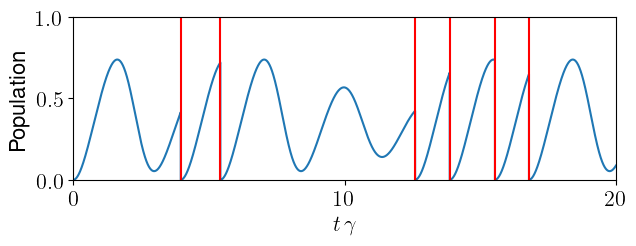

In [33]:
matrix = np.real(prob_delta_time).transpose()
aspect = 0.3

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,5))

c = ax
c.plot(tlist,pop_time)
plt.xlim(0,tfin)  
c.set_box_aspect(aspect)
for time in np.cumsum(taus):
    c.axvline(time, color = 'red')
c.set_xlabel('$t\, \\gamma$')
c.set_ylabel('Population')
c.set_ylim(0,1.)
c.set_xticks([0, 10, 20])

plt.savefig("figures/fig2_a.pdf")

plt.show()

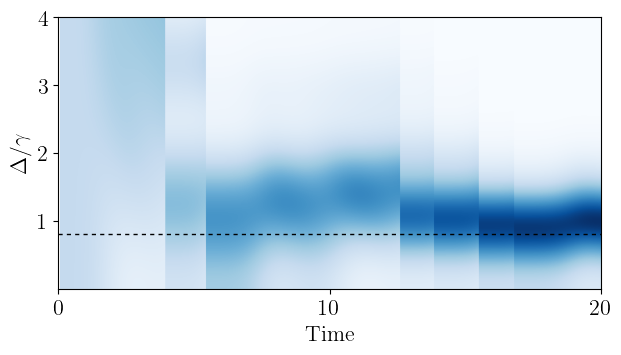

In [69]:
matrix = np.real(prob_delta_time).transpose()
aspect = 0.5

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))
extent = [0,tfin, delta_min, delta_max]

c = ax
c.imshow(matrix, extent=extent, aspect = aspect*extent[1]/extent[3], cmap = "Blues", origin = "lower")
c.set_xlabel("$\\mathrm{Time}$"); 
c.set_ylabel("$\Delta/\\gamma$"); 
c.set_box_aspect(aspect)
c.axhline(delta_sel,linewidth=1, color='black', dashes = [3., 3.])
c.set_xticks([0, 10, 20])

plt.savefig("figures/fig2_b.pdf")

plt.show()

### Figure 2 (c)

In [21]:
Omega = 1

deltamin = 0.; deltamax = 5.; ndelta_w = 100; deltagrid = np.linspace(deltamin,deltamax,ndelta_w)
paramList  = [[Omega, Delta] for Delta in deltagrid]
taumax = 10.; ntau = 500;

taulist = np.linspace(0,taumax,ntau)

wtaumatrix = np.asarray([compute_waiting_time_list(params, taulist) for params in paramList])
poplist = np.asarray([compute_population_ss(params) for params in paramList])
tau_mean = 1/poplist[i_delta]


In [22]:
# Select a particular delta for the plots
i_delta = 15
delta_sel = deltalist[i_delta]
tau_mean = 1/poplist[i_delta]

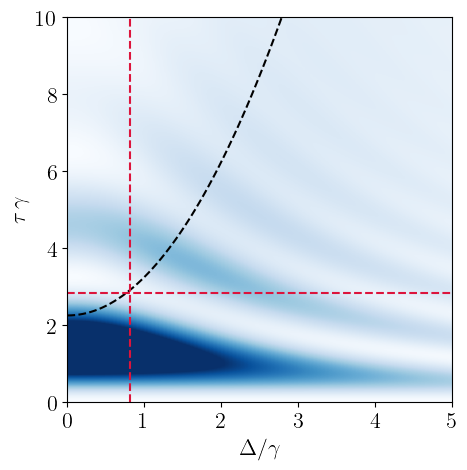

In [77]:
aspect = 1
matrix = wtaumatrix.T
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(5,5))
extent = [deltamin, deltamax,0,taumax]

c = ax
vmax = 0.3
from matplotlib import colors
wtaunorm=colors.TwoSlopeNorm(vmin=0, vcenter=vmax/2, vmax=vmax)

pcm=c.imshow(matrix, extent=extent, aspect = aspect*extent[1]/extent[3], norm=wtaunorm,cmap="Blues", origin = 'lower' )
c.plot(deltagrid, 1/poplist, '--', color = "black")
c.set_xlim(deltamin,deltamax)
c.set_ylim(0,taumax)
c.set_ylabel("$\\tau\, \\gamma$"); 
c.set_xlabel("$\\Delta/\\gamma$"); 

c.axvline(delta_sel, color = 'crimson', linestyle='--',)
c.axhline(tau_mean, color = 'crimson', linestyle='--',)
c.set_box_aspect(aspect)

plt.savefig("figures/fig2_c.pdf")


plt.show()

### Figure 2(d): Histograms of time delays 

In [50]:
nsetsplot = 10000

trajectories_plot=jumpsSetDelta[i_delta][:nsetsplot]

#Turn into histogram
nbins = 50
taumaxplot=10
bins = np.linspace(0,taumaxplot,nbins)

histogram_list = np.zeros([len(trajectories_plot), nbins-1])
for idx, delays in enumerate(trajectories_plot):
    histogram_list[idx] = np.histogram(delays,bins=bins, density=True)[0]
histogram_list = np.asarray(histogram_list)

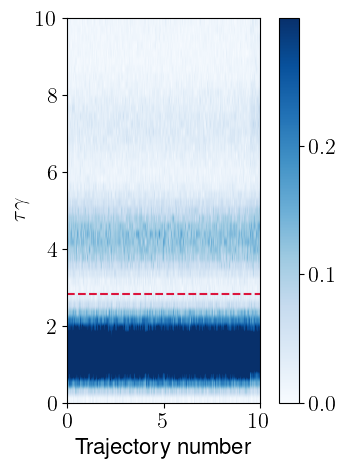

In [76]:
fig, ax = plt.subplots(figsize=(5,5))
aspect = 2
extent=[0,nsetsplot/1000, 0,taumaxplot]
pcm = ax.imshow(histogram_list.T, extent=extent, aspect = aspect*extent[1]/extent[3], cmap = "Blues", norm=wtaunorm, origin="lower" )
ax.set_ylabel("$\\tau \gamma$")
ax.set_xlabel("Trajectory number")
ax.set_box_aspect(2)
ax.axhline(tau_mean, color = 'crimson', linestyle='--',)
fig.colorbar(pcm, ax=ax,location='right', ticks= [0., 0.1, 0.2])
plt.savefig("figures/fig2_d.pdf")
plt.show()

### Figure 2(e)

We select a vale of $\Delta$ and find the mean time delay 

$\bar\tau =\sum_i \tau_i /N $ 

 measured in each trajectory

In [61]:
njumps = 48
taumean_list = np.sum(jumpsSetDelta[i_delta],axis = 1)/njumps

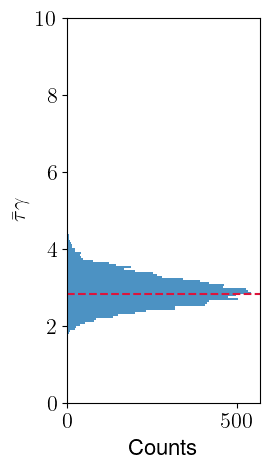

In [75]:
fix, ax = plt.subplots(figsize = (5,5))
ax.hist(taumean_list, bins = 60, density = False, orientation="horizontal", alpha = 0.8)
ax.set_xlabel('$T = \sum_i \\tau_i$')
ax.set_ylabel('$\\bar\\tau \\gamma $')
ax.set_xlabel("Counts")
ax.set_ylim(0,taumax)
ax.set_box_aspect(aspect)
ax.axhline(tau_mean, color = 'crimson', linestyle='--',)
plt.savefig("figures/fig2_e.pdf")
plt.show()

## Figure 3: Benchmarking models for 1D parameter estimation

### Define benchmarking function

In [16]:
def benchmark_predictor(predictor_fun, theta_list = deltalist, Data_array = jumpsSetDelta, progress_bar = True):
    """
    Returns benchmarks of a predictor over a list of values of the ground truth

    Parameters:
    -----------
    predictor_fun (function): Function that takes data and returns a prediction.
    theta_list: Array of ground truth values with size (ntheta, d), ntheta the number of values in the list, d the dimensionality of theta
    Data_array: Array of data with size (N_ground, nsets, N). Each ground truth value has a number nsets of measurements, each measurement consists of N data points.

    Returns:
    -----------
    list: A list of figures of merit of the predictor (mean squared error, list of estimations, root mean squared error, standard deviations)
    """
    
    ntheta = len(theta_list)
    MSE_list = []
    RMSE_list = []
    Estimation_list = []
    sdMSE_list = []
    sdRMSE_list = []
   
    if progress_bar == True:
        def bar(x):
            return tqdm(x)
    else:
        def bar(x):
            return x
   
    for i_delta in bar(range(ntheta)): # Loop over thetas
        
        theta=theta_list[i_delta] # Ground truth
        d = theta.size # Dimension of parameter space
        taus_matrix = Data_array[i_delta]
        ndata = len(taus_matrix) #Number of data points

        # ====== Perform the prediction =========
        theta_pred = np.reshape(
            predictor_fun(taus_matrix), 
            (ndata,d) )
        # =======================================
        diff = theta_pred - theta

        # Mean Squared Error: Mean of the sample of Squared errors
        MSE = np.mean(np.sum(diff**2,axis=-1))
        # Sample-standard-deviation of the sample of Squared Errors (gives variance estimate)
        sdSE = sqrt(np.var(np.sum(diff**2,axis=-1), ddof = 1))
        MSE_list.append(MSE)
        RMSE_list.append(sqrt(MSE))
        sdMSE_list.append(sdSE)
        sdRMSE = 0.5/sqrt(MSE)*sdSE
        sdRMSE_list.append(sdRMSE)
        Estimation_list.append(theta_pred)

    Estimation_list = np.asarray(Estimation_list)
    MSE_list = np.asarray(MSE_list)
    RMSE_list = np.asarray(RMSE_list)
    sdMSE_list = np.asarray(sdMSE_list)
    sdRMSE_list = np.asarray(sdRMSE_list)

    return MSE_list, Estimation_list, RMSE_list, sdMSE_list, sdRMSE_list

### Classical estimation

In [17]:
import numpy as np

def delta_pred_TLS_Classical(T:float, Omega:float = 1., gamma:float = 1., n:float = 48)-> float:
    """
    Calculate the predicted value of delta from classical estimations.

    Parameters:
    T: Total evolution time.
    Omega: Rabi frequency of the drive.
    gamma: Spontaneous emission rate.
    n: Number of clicks.

    Returns:
    float: Predicted delta value.
    """
    # Convert the input temperatures to complex numbers
    T = T.astype(complex)
    
    # Calculate the predicted delta using the TLS model formula
    delta = np.real(
        np.sqrt((4 * T * gamma * Omega**2 - n * (gamma**2 + 8 * Omega**2))) /
        (2 * np.sqrt(n))
    )
    
    return delta

# Define predictor function 

def predictor_classical(taus_matrix):
    tflist=np.sum(taus_matrix,axis =1)     

    return np.array([
        delta_pred_TLS_Classical(T) 
                     for T in tflist])


def calculate_Ptau_gaussian(tau, Delta,Omega=1.,gamma=1., N=48):
    sigma = np.sqrt(((gamma**2 + 4*Delta**2)**2 - 8*(gamma**2 - 12*Delta**2)*Omega**2 + 64*Omega**4)/(N*gamma**2 * Omega**4))/4
    mu = (gamma**2 + 4*Delta**2 + 8*Omega**2)/(4*gamma*Omega**2)
    return np.exp(-0.5*((tau-mu)/sigma)**2)/(sigma*np.sqrt(2*np.pi))

def predictor_classical_Mean_tau(tau):
    ''' 
    Returns estimator based on the mean of the posterior
    '''
    delta_list = np.linspace(0., 5., 200)
    PT_Delta_list = calculate_Ptau_gaussian(tau,delta_list)
    norm = np.trapz(PT_Delta_list, delta_list)
    #Posterior
    PDelta = PT_Delta_list/norm
    Delta_mean = np.trapz(PDelta*delta_list,delta_list)
    return Delta_mean
    
# Define predictor function 
def predictor_classical(taus_matrix):
    taulist=np.mean(taus_matrix,axis =1)     

    return np.array([
        predictor_classical_Mean_tau(tau) 
                     for tau in taulist])

In [18]:
MSE_Class, estimationsClassical, RMSE_Class, sdMSE_Class, sdRMSE_Class = benchmark_predictor(predictor_classical)

  0%|          | 0/40 [00:00<?, ?it/s]

 32%|███▎      | 13/40 [00:04<00:09,  2.99it/s]

Root Mean Squared Error (RMSE)

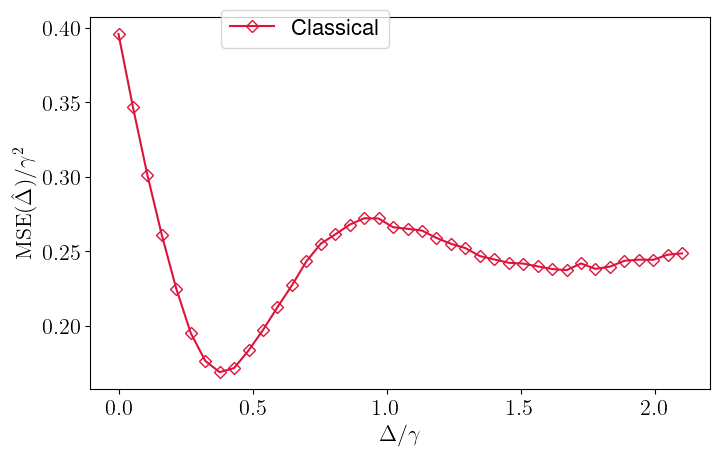

In [22]:
fix, ax = plt.subplots(figsize=(8,8))

color = "crimson"
ax.plot(deltalist,RMSE_Class, 'D-',  label= "Classical", color = color,markerfacecolor='none')

ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{MSE}(\hat\Delta)/\gamma^2$")
ax.set_box_aspect(0.6)
ax.legend( bbox_to_anchor=(0.5, 1.05))
plt.show()

### Quantum data: Bayesian estimation

Here we do not use ```benchmark_predictor(predictor_fun)```, since the Bayesian calculation produces a posterior distribution, from which several estimators can be built. 
With a single calculation of the posterior, we extract the following estimators:

- *Mean* of the posterior $\hat\theta = \int d\theta P(\theta|D)\theta$
- *Maximum* of the posterior $\hat\theta = \mathrm{argmax}_\theta P(\theta|D)$
- *Median* of the posterior $\hat\theta = \mathrm{med}[P(\theta|D)]$

Results shown in the paper correspond to the *mean* estimator.

In [23]:
def predictors_bayesian(data, deltalist=deltalist, nBayesGrid = 500, progress_bar = True, only_mean = False):
    
    if progress_bar == True:
        def bar(x):
            return tqdm(x)
    else:
        def bar(x):
            return x
    estimate_array_delta = []
    for i_delta in bar(range(deltalist.size)): #Bucle sobre deltas
        trajectory_matrix = data[i_delta]

        estimate_array = parallel_map(get_estimates_Bayesian,trajectory_matrix, task_kwargs=dict(nDeltaGrid=nBayesGrid, only_mean = only_mean))
        estimate_array_delta.append(estimate_array)

    estimate_array_delta = np.asarray(estimate_array_delta)

    if only_mean == True:
        estimationsBayes1D = estimate_array_delta
        return estimationsBayes1D
    
    estimationsBayes1D = estimate_array_delta[:,:,0]
    estimationsBayes1D_median = estimate_array_delta[:,:,1]
    estimationsBayes1D_max = estimate_array_delta[:,:,2]
    return estimationsBayes1D, estimationsBayes1D_median, estimationsBayes1D_max        

In [70]:
nsets = 10000
jumpsSetDeltaList = [jumpsSet[:nsets] for jumpsSet in jumpsSetDelta]

path_folder = datapath+'results_cache/bayesian_estimation/1D/'
path_cached_results_mean = path_folder+'estimationBayes1D_mean.npy'
path_cached_results_max = path_folder+'estimationBayes1D_max.npy'
path_cached_results_median= path_folder+'estimationBayes1D_median.npy'


if not os.path.isfile(path_cached_results_mean):
    print("Estimation not found: Computing.")

    estimationsBayes1D, estimationsBayes1D_median, estimationsBayes1D_max = predictors_bayesian(jumpsSetDeltaList)
    create_directory(path_folder)
    np.save(path_cached_results_mean,estimationsBayes1D) 
    np.save(path_cached_results_max,estimationsBayes1D_max) 
    np.save(path_cached_results_median,estimationsBayes1D_median) 

else:
    print("We found a cached estimation: Loading.")
    estimationsBayes1D = np.load(path_cached_results_mean)
    estimationsBayes1D_max = np.load(path_cached_results_max)
    estimationsBayes1D_median = np.load(path_cached_results_median)



We found a cached estimation: Loading.


In [25]:
MSE_Bayes_Mean = np.array([np.mean((estimationsBayes1D[i]-deltalist[i])**2) for i in range(ndelta)])
varMSE_Bayes_Mean = np.array([np.var((estimationsBayes1D[i]-deltalist[i])**2) for i in range(ndelta)])
RMSE_Bayes_Mean = np.sqrt(MSE_Bayes_Mean)

MSE_Bayes_Max = np.array([np.mean((estimationsBayes1D_max[i]-deltalist[i])**2) for i in range(ndelta)])
MSE_Bayes_Median = np.array([np.mean((estimationsBayes1D_median[i]-deltalist[i])**2) for i in range(ndelta)])


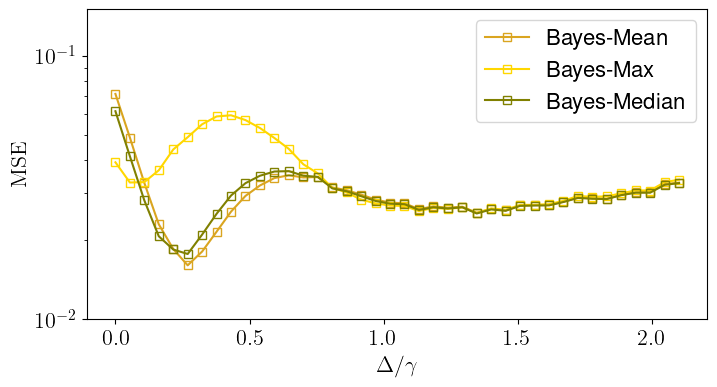

In [26]:
fix, ax = plt.subplots(figsize=(8,8))
ax.plot(deltalist,MSE_Bayes_Mean,'s-', label= 'Bayes-Mean',  color = "goldenrod", markerfacecolor='none')
ax.plot(deltalist,MSE_Bayes_Max,'s-', label= 'Bayes-Max',  color = "gold", markerfacecolor='none')
ax.plot(deltalist,MSE_Bayes_Median,'s-', label= 'Bayes-Median',  color = "olive", markerfacecolor='none')


ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{MSE}$"), ax.set_yscale("log"),
ax.set_box_aspect(0.5)
ax.set_ylim(0.01,0.15)
ax.legend()

plt.show()

### RNN model 

In [27]:
model=keras.models.load_model(datapath+"models/1D/model-RNN.h5", compile=False)

In [ ]:
MSE_RNN, estimationsRNN, RMSE_RNN, sdMSE_RNN, sdRMSE_RNN = benchmark_predictor(model)

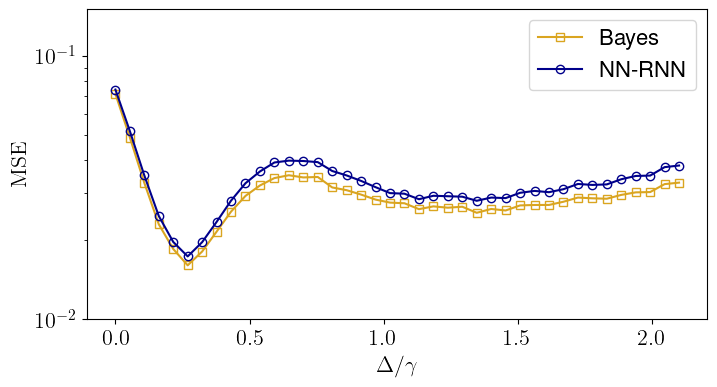

In [29]:
fix, ax = plt.subplots(figsize=(8,8))
ax.plot(deltalist,MSE_Bayes_Mean,'s-', label= 'Bayes',  color = "goldenrod", markerfacecolor='none')
ax.plot(deltalist,MSE_RNN, 'o-',  label= "NN-RNN",color = "darkblue",markerfacecolor='none')

ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{MSE}$"), ax.set_yscale("log"),
ax.set_box_aspect(0.5)
ax.set_ylim(0.01,0.15)
ax.legend()

plt.show()

### Hist-Dense model

In [12]:
from paramest_nn.custom_layers import MyHistogramLayer_Sigmoid, histogram_sigmoid

Load model

In [13]:
modelname = 'model-Hist.h5'
modelHist=keras.models.load_model(datapath+f"models/1D/{modelname}", compile=False)

In [ ]:
MSE_Hist, estimationsHist, RMSE_Hist, sdMSE_Hist, sdRMSE_Hist = benchmark_predictor(modelHist)

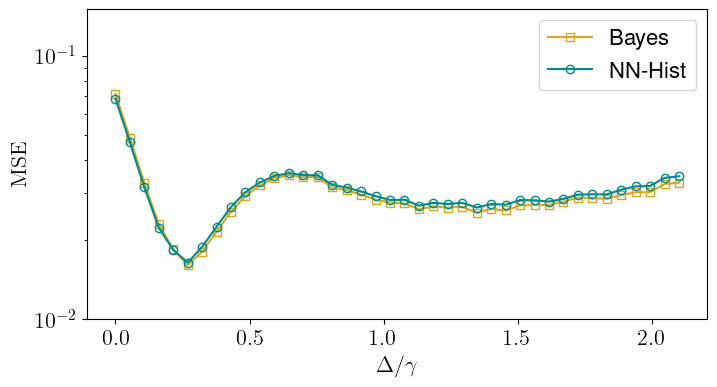

In [33]:
fix, ax = plt.subplots(figsize=(8,8))
ax.plot(deltalist,MSE_Bayes_Mean,'s-', label= 'Bayes',  color = "goldenrod", markerfacecolor='none')
ax.plot(deltalist,MSE_Hist, 'o-',  label= "NN-Hist",color = "darkcyan",markerfacecolor='none')
#ax.plot(deltalist,MSE_Class, 'D-',  label= "Classical", color = "crimson",markerfacecolor='none')


ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{MSE}$"), ax.set_yscale("log"),
ax.set_box_aspect(0.5)
ax.set_ylim(0.01,0.15)
ax.legend()

plt.show()

### Plotting all together

#### Figure 3(a): Estimation scatter plots

In [34]:
nscatter = 500 # Number of points per delta to show in the scatter plot

delta_data = np.tile(deltalist, (nscatter, 1)).T.flatten()

estim_data_RNN= estimationsRNN[:,:nscatter].flatten()
estim_data_Classical= estimationsClassical[:,:nscatter].flatten()
estim_data_Hist= estimationsHist[:,:nscatter].flatten()

estim_data_Bayes = estimationsBayes1D[:,:nscatter].flatten()
estim_data_Bayes_Max = estimationsBayes1D_max[:,:nscatter].flatten()
estim_data_Bayes_Median = estimationsBayes1D_median[:,:nscatter].flatten()

meandeltaPred_Classical = np.mean(estimationsClassical,axis=1).flatten()
meandeltaPred_Bayes= np.mean(estimationsBayes1D,axis=1).flatten()
meandeltaPred_RNN = np.mean(estimationsRNN,axis=1).flatten()
meandeltaPred_Hist = np.mean(estimationsHist,axis=1).flatten()

Scatter plots

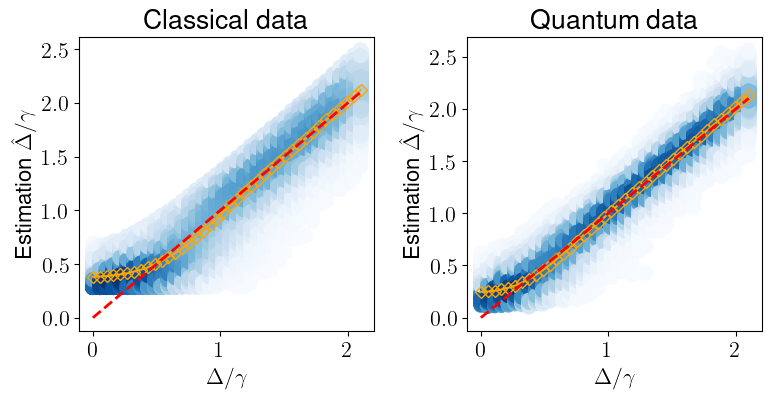

In [35]:
from scipy.stats import gaussian_kde

fig, axis = plt.subplots(ncols = 2, figsize = (8,8))

x = delta_data
aspect = 1.

# Calculate and plot the classical point density
ax = axis[0]
y = estim_data_Classical
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.plot(deltalist,meandeltaPred_Classical, 'D-', color = "orange", markerfacecolor='none')
ax.scatter(x, y, c=z, s=100, cmap = "Blues", rasterized=True)
ax.plot(deltalist,deltalist,'--', color = "red", linewidth='2')
ax.set_xlabel("$\Delta/\\gamma$")
ax.set_ylabel("Estimation $\hat\Delta/\\gamma$")
ax.set_box_aspect(aspect)
ax.set_title("Classical data")
ax.set_xticks([0, 1, 2])
'''# Calculate and plot the Bayesian point density
ax = axis[1]
y = estim_data_Bayes
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.plot(deltalist,meandeltaPred_Bayes, 'D-', color = "goldenrod", markerfacecolor='none')
ax.scatter(x, y, c=z, s=100, cmap = "Blues", rasterized=True)
ax.plot(deltalist,deltalist,'--', color="red", linewidth='2')
ax.set_xlabel("$\Delta/\\gamma$")
ax.set_ylabel("Estimation $\hat\Delta/\\gamma$")
ax.set_box_aspect(aspect)'''

# Calculate and plot the Bayesian point density
ax = axis[1]
y = estim_data_Hist
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.plot(deltalist,meandeltaPred_Hist, 'D-', color = "orange", markerfacecolor='none')
ax.scatter(x, y, c=z, s=100, cmap = "Blues", rasterized=True)
ax.plot(deltalist,deltalist,'--', color="red", linewidth='2')
ax.set_xlabel("$\Delta/\\gamma$")
ax.set_ylabel("Estimation $\hat\Delta/\\gamma$")
ax.set_box_aspect(aspect)
ax.set_title("Quantum data")
ax.set_xticks([0, 1, 2])

fig.tight_layout()
plt.savefig("figures/fig3_a.svg")
plt.show()

#### Fisher information for Photon Counting

Now we compute the Fisher information associated with the particular measurement that we are performing: Photon Counting.
For this, we use the expression in Eq. (5) in [Phys. Rev. A 87, 032115 (2013)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.87.032115)

In [ ]:
# Quantum  data
def der2_trajectory(delta,tau_list):
    epsilon = 0.001
    logptheta1=np.log(compute_likelihood_analytical(delta,tau_list))
    logptheta2=np.log(compute_likelihood_analytical(delta+epsilon,tau_list))
    dptheta = (logptheta2-logptheta1)/epsilon
    return dptheta**2

def get_Fisher_Information_derivative(i_delta):
    trajectory_matrix = jumpsSetDelta[i_delta]
    delta_sel = deltalist[i_delta]
    der2_list = np.asarray([der2_trajectory(delta_sel,tau_list) for tau_list in trajectory_matrix])
    return np.mean(der2_list)


# Classical data
def der2_trajectory_Classical(delta,tau_list):
    epsilon = 0.001
    logptheta1=np.log(compute_likelihood_analytical_Classical(delta,tau_list))
    logptheta2=np.log(compute_likelihood_analytical_Classical(delta+epsilon,tau_list))
    dptheta = (logptheta2-logptheta1)/epsilon
    return dptheta**2

def get_Fisher_Information_derivative_Classical(i_delta):
    trajectory_matrix = jumpsSetDelta[i_delta]
    delta_sel = deltalist[i_delta]
    der2_list = np.asarray([der2_trajectory_Classical(delta_sel,tau_list) for tau_list in trajectory_matrix])
    return np.mean(der2_list)


In [ ]:
FI_list = np.asarray(parallel_map(get_Fisher_Information_derivative,range(len(deltalist)), progress_bar=True))
FI_list_classical = np.asarray(parallel_map(get_Fisher_Information_derivative_Classical,range(len(deltalist)), progress_bar=True))

10.0%. Run time:   7.85s. Est. time left: 00:00:01:10
20.0%. Run time:   7.90s. Est. time left: 00:00:00:31
30.0%. Run time:  15.73s. Est. time left: 00:00:00:36
40.0%. Run time:  15.92s. Est. time left: 00:00:00:23
50.0%. Run time:  16.10s. Est. time left: 00:00:00:16
60.0%. Run time:  24.47s. Est. time left: 00:00:00:16
70.0%. Run time:  24.65s. Est. time left: 00:00:00:10
80.0%. Run time:  24.81s. Est. time left: 00:00:00:06
90.0%. Run time:  31.05s. Est. time left: 00:00:00:03
100.0%. Run time:  31.26s. Est. time left: 00:00:00:00
Total run time:  31.26s
10.0%. Run time:   0.17s. Est. time left: 00:00:00:01
20.0%. Run time:   0.18s. Est. time left: 00:00:00:00
30.0%. Run time:   0.31s. Est. time left: 00:00:00:00
40.0%. Run time:   0.32s. Est. time left: 00:00:00:00
50.0%. Run time:   0.33s. Est. time left: 00:00:00:00
60.0%. Run time:   0.45s. Est. time left: 00:00:00:00
70.0%. Run time:   0.47s. Est. time left: 00:00:00:00
80.0%. Run time:   0.49s. Est. time left: 00:00:00:00
90.

Direct application of the Cramer Rao bound in its usual form does not give consistent results. Since our estimators are *biased*, we need to use the generalized form

$$ \text{var}\,\hat\theta= \frac{[1 + \frac{db(\theta)}{d\theta}]^2}{F(\theta)} $$

For this, we need to compute the derivatives of the variances

In [39]:
biasClassical = meandeltaPred_Classical-deltalist
biasBayes = meandeltaPred_Bayes-deltalist
biasRNN = meandeltaPred_RNN-deltalist
biasHist = meandeltaPred_Hist-deltalist

# Compute derivatives of bias (we smooth data with Cubic Splines for this)

from scipy.interpolate import CubicSpline
from scipy import signal

def get_derivative(x,y):
    yfilt = signal.savgol_filter(y,7,3) 
    xFine = np.linspace(np.min(x), np.max(x), len(x))
    yfun = CubicSpline(x,yfilt)
    yFine= yfun(xFine)
    derYFine = np.gradient(yFine,xFine)
    derYfun = CubicSpline(xFine,derYFine)
    derY = derYfun(x)
    return derY


derBiasClassical = get_derivative(deltalist,biasClassical)
derBiasBayes = get_derivative(deltalist,biasBayes)
derBiasRNN =  get_derivative(deltalist,biasRNN)
derBiasHist =   get_derivative(deltalist,biasHist)

From the derivatives, we can now define the generalized Cramer Rao bounds (Fisher information).

In [40]:
CRB_Class = sqrt( (1 + derBiasClassical)**2/FI_list_classical)
CRB_Bayes = sqrt( (1 + derBiasBayes)**2/FI_list)

#### Fig. 3 (b): RMSE plots

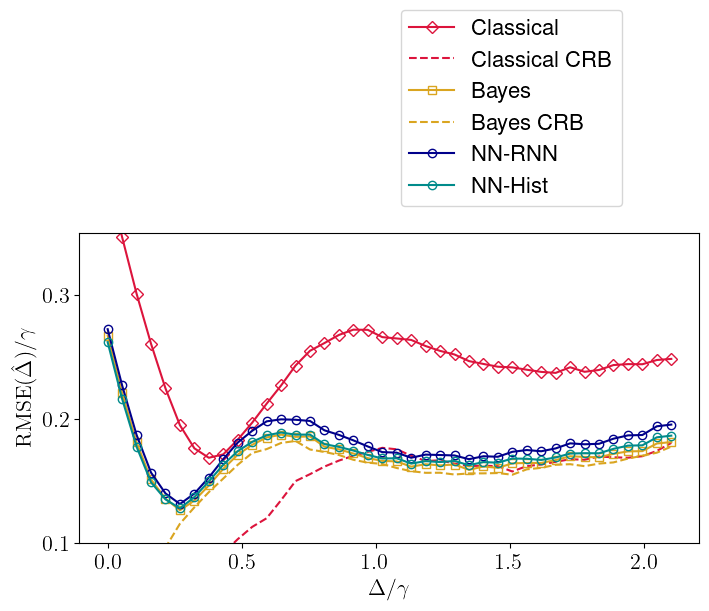

In [60]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(deltalist,RMSE_Class, 'D-',  label= "Classical", color = "crimson",markerfacecolor='none')
ax.plot(deltalist,CRB_Class, '--',  label= "Classical CRB", color = "crimson",markerfacecolor='none')

ax.plot(deltalist,RMSE_Bayes_Mean,'s-', label= 'Bayes',  color = "goldenrod", markerfacecolor='none')
ax.plot(deltalist,CRB_Bayes,'--', label= 'Bayes CRB',  color = "goldenrod", markerfacecolor='none')

ax.plot(deltalist,RMSE_RNN,  'o-',label= 'NN-RNN' , color = "darkblue",markerfacecolor='none')
ax.plot(deltalist,RMSE_Hist, 'o-',  label= "NN-Hist",color = "darkcyan",markerfacecolor='none')


ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{RMSE}(\hat\Delta)/\gamma$")
ax.set_box_aspect(0.5)
ax.set_yticks([0., 0.1, 0.2, 0.3])
ax.set_ylim(0.1,0.35)
ax.legend( bbox_to_anchor=(0.5, 1.05))
plt.savefig("figures/fig3_b.pdf")
plt.savefig("figures/fig3_b.svg")
plt.show()

#### Fig 3(c): Bias plots

(Check https://www.statslab.cam.ac.uk/Dept/People/djsteaching/S1B-15-02-estimation-bias-4.pdf for quick notes on bias)

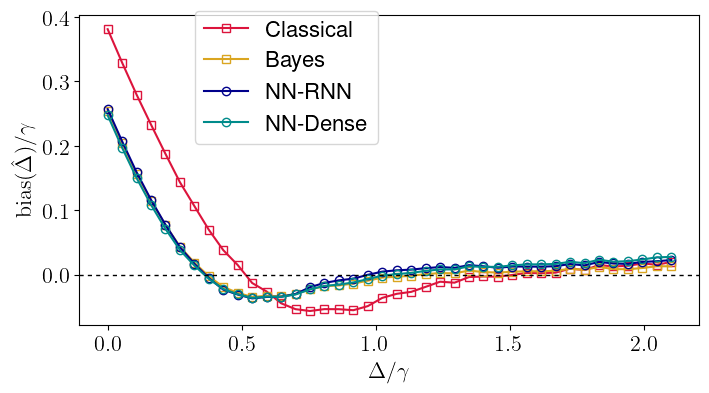

In [61]:
fix, ax = plt.subplots(figsize=(8,8))

ax.plot(deltalist,meandeltaPred_Classical-deltalist,'s-', label= 'Classical',  color = "crimson", markerfacecolor='none')
ax.plot(deltalist,meandeltaPred_Bayes-deltalist,'s-', label= 'Bayes',  color = "goldenrod", markerfacecolor='none')
ax.plot(deltalist,meandeltaPred_RNN-deltalist,  'o-',label= 'NN-RNN' , color = "darkblue",markerfacecolor='none')
ax.plot(deltalist,meandeltaPred_Hist-deltalist, 'o-',  label= "NN-Dense",color = "darkcyan",markerfacecolor='none')

ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\mathrm{bias}(\hat\Delta)/\gamma$"), 
ax.set_box_aspect(0.5)
ax.legend( bbox_to_anchor=(0.5, 1.05))
ax.axhline(0.,linewidth=1, color='black', dashes = [3., 3.])
plt.savefig("figures/fig3_c.pdf")
plt.savefig("figures/fig3_c.svg")

plt.show()

## Figure 4: Benchmarking for 2D estimation

### Bayesian estimation

We work with data that has been saved in different batches (for parallelization). 
In our case, we have saved the validation trajectories in 10 different batches.
The number of batches was set in "1-Trajetories-generation.ipynb".

In [ ]:
# Number of parameter pairs that were simulated for validation
nparams = 1600

# Number of trajectories that were simulated per parameter pair
nsets = 10000

# Number of batches in which the trajectories were divided 
nbatches = 10

# Number of trajectories per batch that correspond to a specific parameter pair
traj_per_param_pair = int(nsets/nbatches)

Load predictions

In [ ]:
prediction_list = [np.load(
    datapath+f"results_cache/bayesian_estimation/2D/estimationBayes2DUltranest/uniform_2d_predictions_{idx_data}.npy"
) for idx_data in range(nbatches)]

We define some functions to handle this data and output the corresponding predictions

In [ ]:
def select_prediction_param(i_param:int, pred_list_from_batch: list, traj_per_param_pair:int):
    '''
    Giving the list of predictions from a single batch, this function selects those corresponding to trajectories that were generated from a
    specific parameter pair, indexed by "i_param". This pair corresponds to the true value of the parameters, while this function will output the corresponding predictions.
    The number of predictions selected is given by "traj_per_param_pair".

    Parameters
    ----------
    i_param (int): Index characterizing the parameter-pair (Delta,Omega) of the trajectories to be analized.
    pred_list_from_batch (list): Full list of predictions from a single batch of data
    traj_per_param_pair (int): Number of trajectories corresponding to a single parameter-pair in each batch

    Returns
    ----------
    List of predictions corresponding only to the trajectories obtained from the parameter-pair with index "i_param"
    '''
    return list(pred_list_from_batch[(i_param)*traj_per_param_pair:(i_param+1)*traj_per_param_pair])

We now compare the predictions with the true parameters and compute the covariance matrix

In [ ]:
MSE_Bayes2D = []

# Compute the covariance matrix

for i_param in tqdm(range(nparams)): # Loop over parameter-pairs

    delta=paramlist[i_param][0]
    omega = paramlist[i_param][1]
    params = np.array(paramlist[i_param])

    deltas_pred_mean_ALL = []
    omega_pred_mean_ALL = []

    for idx_batch in range(nbatches):
        omega_preds_mean, delta_preds_mean = prediction_list[idx_batch]
        
        deltas_pred_mean_ALL+=select_prediction_param(i_param, delta_preds_mean, traj_per_param_pair)
        omega_pred_mean_ALL+=select_prediction_param(i_param, omega_preds_mean, traj_per_param_pair)

    diff_delta=(deltas_pred_mean_ALL-params[0])
    diff_omega=(omega_pred_mean_ALL-params[1])
    
    MSE = np.mean(diff_delta**2) + np.mean(diff_omega**2)
    MSE_Bayes2D.append(MSE)

MSE_Bayes2D = np.asarray(MSE_Bayes2D)


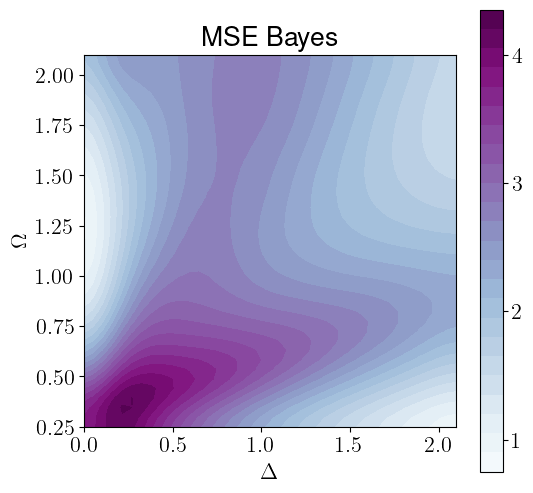

In [ ]:
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter

levels = 4
deltaGrid = np.sort(np.unique(paramlist[:,0]))
OmegaGrid = np.sort(np.unique(paramlist[:,1]))
XX, YY = np.meshgrid(deltaGrid,OmegaGrid)

MSE_Bayes_matrix = MSE_Bayes2D.reshape(40,40)
MSE_Bayes_matrix = gaussian_filter(MSE_Bayes_matrix,sigma = 2)

fig, axis = plt.subplots(ncols=1,nrows=1,figsize=(6,6))

ax = axis
pcm=ax.contourf(XX,YY,-np.log(MSE_Bayes_matrix),cmap='BuPu',levels = 30)

cbar = fig.colorbar(pcm, ax=ax)
ticks = [1,2,3,4]
# Define your desired tick values
# Create a ticker object with your desired tick values
ticker_obj = ticker.FixedLocator(ticks)
# Set the ticker object for the colorbar
cbar.locator = ticker_obj
# Update the ticks and labels on the colorbar
cbar.update_ticks()
ax.set_box_aspect(1)
ax.set_title("MSE Bayes")
ax.set_xlabel("$\\Delta$")
ax.set_ylabel("$\\Omega$")



plt.show()

### Hist-Dense model

In [ ]:
from paramest_nn.custom_layers import MyHistogramLayer_Sigmoid
modelname = "model-Hist-Dense-2D"
model=keras.models.load_model(datapath+"models/2D/"+modelname+'.h5', compile=False);

In [ ]:
nsets = 10000 # Trajs. per parameter
path_folder = datapath+f"results_cache/bayesian_estimation/2D/estimationNN/"
path_results_model2D = path_folder + f"estimation-{modelname}"
isMSEfile=os.path.isfile(path_results_model2D+".npy")

if isMSEfile:
    print("We found cached results for the validation of the model. Loading.")
    MSE_NN_2D = np.load(path_results_model2D+".npy")
else:
    print("We did not found cached results for the validation of the model. Computing.")
    MSE_NN_2D= benchmark_predictor(model, theta_list = paramlist, Data_array = jumpsSetParams)[0]
    create_directory(path_folder)
    np.save(path_results_model2D,MSE_NN_2D) 

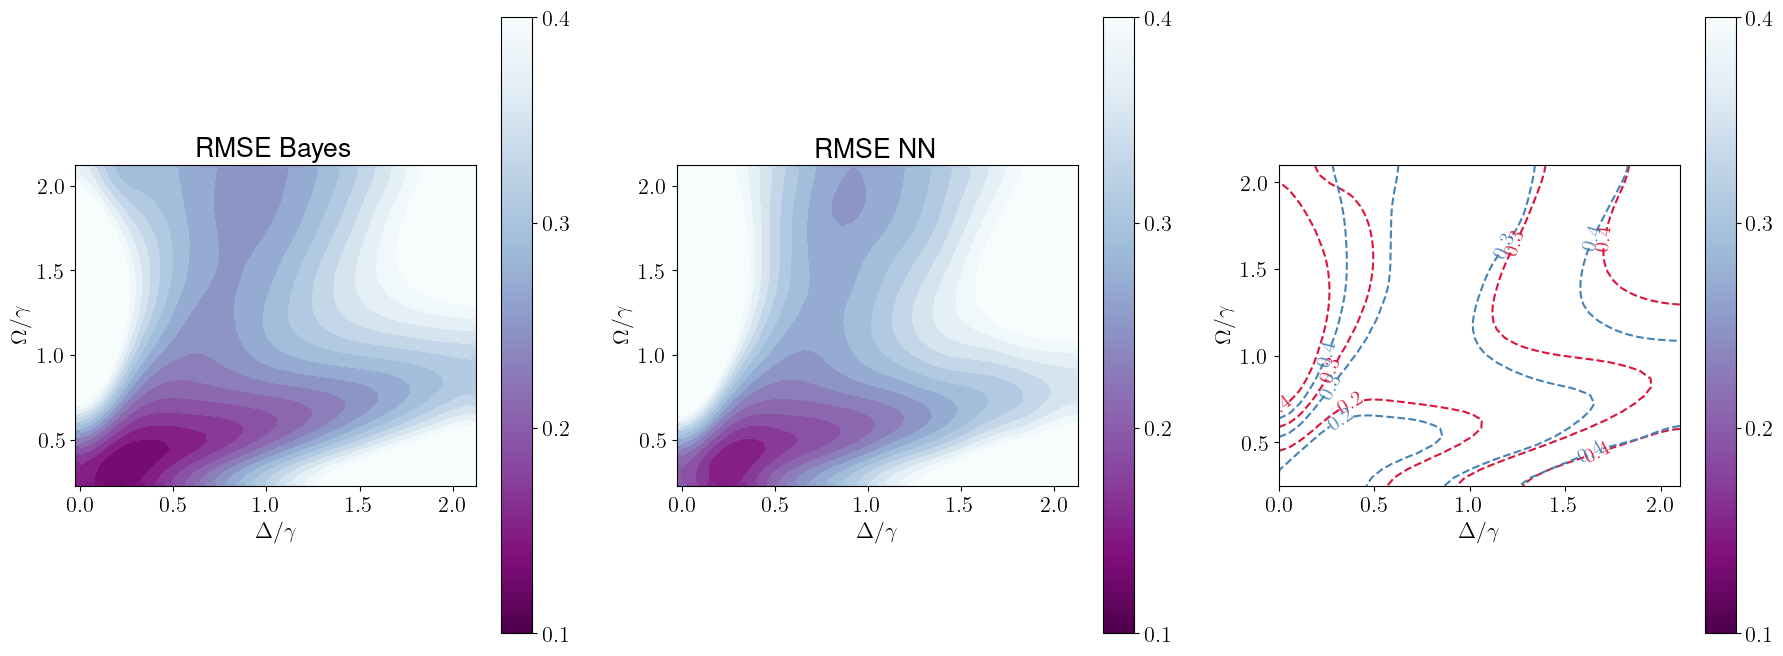

In [ ]:
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

levels = [0.2,0.3,0.4]
ticks = [0.1,0.2, 0.3,0.4,0.5]
aspect = 0.8


cmap = plt.get_cmap('BuPu').reversed()
# Create a color normalization instance with the specified minimum and maximum
vmin = 0.1; vmax = 0.4
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

# Define the matrices to plot
MSE_Bayes_matrix = MSE_Bayes2D.reshape(40,40)
MSE_Bayes_matrix = gaussian_filter(MSE_Bayes_matrix,sigma = 2)
MSE_NN_matrix = MSE_NN_2D.reshape(40,40)
MSE_NN_matrix = gaussian_filter(MSE_NN_matrix,sigma = 2)

fig, axis = plt.subplots(ncols=3,nrows=1,figsize=(22,8))

ax = axis[0]
pcm=ax.pcolormesh(XX,YY,np.sqrt(MSE_Bayes_matrix),cmap=cmap,vmin = vmin, vmax = vmax)
ax.contourf(XX,YY,np.sqrt(MSE_Bayes_matrix),cmap=cmap,levels = 30,vmin = vmin, vmax = vmax)
fig.colorbar(pcm, ax=ax,location='right', ticks= ticks)
ax.set_box_aspect(aspect)
ax.set_title("RMSE Bayes")
ax.set_xlabel("$\\Delta/\\gamma$")
ax.set_ylabel("$\\Omega/\\gamma$")

ax = axis[1]
pcm=ax.pcolormesh(XX,YY,np.sqrt(MSE_NN_matrix),cmap=cmap,vmin = vmin, vmax = vmax)
ax.contourf(XX,YY,np.sqrt(MSE_NN_matrix),cmap=cmap,levels = 30,vmin = vmin, vmax = vmax)
fig.colorbar(pcm, ax=ax,location='right', ticks= ticks)
ax.set_box_aspect(aspect)
ax.set_title("RMSE NN")
ax.set_xlabel("$\\Delta/\\gamma$")
ax.set_ylabel("$\\Omega/\\gamma$")

ax = axis[2]
cp=ax.contour(XX,YY,np.sqrt(MSE_Bayes_matrix),colors='crimson',levels = levels, linestyles = 'dashed')
ax.clabel(cp, inline=True, fontsize=15)
cp = ax.contour(XX,YY,np.sqrt(MSE_NN_matrix),colors='steelblue',levels = levels, linestyles = 'dashed')
ax.clabel(cp, inline=True, fontsize=15)
fig.colorbar(pcm, ax=ax,location='right', ticks= ticks)
ax.set_box_aspect(aspect)
ax.set_xlabel("$\\Delta/\\gamma$")
ax.set_ylabel("$\\Omega/\\gamma$")

plt.savefig("figures/fig4.svg")
plt.savefig("figures/fig4.pdf")

plt.show()

## Figure 5: Robustness against noise

### Noise in x-train

- This evaluation requires a populated `data/models/1D/noise-x-train` folder. 

- This folder is populated by running the notebook `1-Training`

- The array of $\sigma$ considered here should match the one used to train the models in `data/models/1D/noise-x-train`

In [ ]:
sigma_min = 0.;sigma_max = 1.;nsigma = 30; sigma_list = np.linspace(0,sigma_max,nsigma)
from paramest_nn.custom_layers import MyHistogramLayer_Sigmoid

#### Loop over $\Delta$ for different $\sigma$ values

In [ ]:
def compute_MSE_Bayes_noise_xtrain(idx_sigma, nsets = 10000):
    sigma = sigma_list[idx_sigma]
    seed = 1

    noise = np.random.default_rng(seed).normal(0.,sigma, jumpsSetDelta[0].shape)
    jumpsSetDeltaNoise = [((trajectory_matrix + noise).clip(min=1E-3))[:nsets] for trajectory_matrix in jumpsSetDelta]
    estimationsBayesNoisy = predictors_bayesian(jumpsSetDeltaNoise, nBayesGrid = 100, progress_bar = False, only_mean = True)
    MSE_Bayes_Mean_Noisy = np.array([np.mean((estimationsBayesNoisy[i]-deltalist[i])**2) for i in range(ndelta)])
    return MSE_Bayes_Mean_Noisy

def compute_MSE_NeuralNetwork_noise_xtrain(idx_sigma, nsets = 10000):
    sigma = sigma_list[idx_sigma]
    seed = 1

    noise = np.random.default_rng(seed).normal(0.,sigma, jumpsSetDelta[0].shape)
    jumpsSetDeltaNoise = [((trajectory_matrix + noise).clip(min=1E-3))[:nsets] for trajectory_matrix in jumpsSetDelta]

    #Load the model
    model=keras.models.load_model(datapath+f"models/1D/noise-x-train/model_best_Hist-sigma_{sigma}.hdf5",compile=False)
    # Compute benchmarks
    MSE_NN_Noisy = benchmark_predictor(model, Data_array = jumpsSetDeltaNoise, progress_bar = False)[0]
    return MSE_NN_Noisy

In [ ]:
idx_initial = 15
idx_final = 29
npoints = 2
nsets = 10000
step = round((idx_final-idx_initial)/npoints)
cmap = matplotlib.colormaps["GnBu"].reversed()
sigma_idx_list = range(idx_initial, idx_final, step)

In [ ]:
path_folder_cache = datapath+'results_cache/x_noise/'
path_cached_results_x_noise= path_folder_cache + 'results_MSE_xnoise.pkl'

if not os.path.isfile(path_cached_results_x_noise):
    print("No cached results found: Computing...")
    MSE_noise_x_results = []
    for idx_sigma in tqdm(sigma_idx_list):
        MSE_Bayes_Mean_Noisy = compute_MSE_Bayes_noise_xtrain(idx_sigma, nsets = nsets)
        MSE_NN_Noisy = compute_MSE_NeuralNetwork_noise_xtrain(idx_sigma, nsets = nsets)
        MSE_noise_x_results.append([MSE_Bayes_Mean_Noisy, MSE_NN_Noisy ])
    results_x_noise = [MSE_noise_x_results, ]

    # Save the results to a file using pickle
    create_directory(path_folder_cache)
    with open(path_cached_results_x_noise, 'wb') as file:
        pickle.dump(MSE_noise_x_results, file)
else:
    print("We found cached results: Loading.")
    # Load the results from the file in cache
    with open(path_cached_results_x_noise, 'rb') as file:
        MSE_noise_x_results = pickle.load(file)

#### Loop over $\sigma$ for a fixed $\Delta$ value

In [ ]:
i_delta = 5 
delta = deltalist[i_delta]
trajectory_matrix = jumpsSetDelta[i_delta]

We loop over $\sigma$, addding noise to the validation trajectories. We make predictions using the corresponding model trained with data with the same noise, and also make a Bayesian estimation with a model that does not account for noise.

In [ ]:
rmse_sigma = []
rmse_sigma_NN = []
estimate_Bayes_array = []
estimate_NN_array = []

seed = 1
# nsets can be as high as 10k (the total number of validation trajectories per delta value)
nsets = 10000

for sigma in tqdm(sigma_list):
    noise = np.random.default_rng(seed).normal(0.,sigma, trajectory_matrix.shape)
    trajectory_matrix_noise = ((trajectory_matrix + noise).clip(min=1E-3))[:nsets]

    # Bayesian estimation
    estimate_array = np.array(
        parallel_map(get_estimates_Bayesian,trajectory_matrix_noise, task_kwargs=dict(nDeltaGrid=100, only_mean = True))
        )
    estimate_Bayes_array.append(estimate_array)
    est_mean_anal = estimate_array
    rmse_mean = sqrt(np.mean((est_mean_anal - delta)**2))
    rmse_sigma.append(rmse_mean)


    # Estimation via Neural Networks
    model=keras.models.load_model(datapath+f"models/1D/noise-x-train/model_best_Hist-sigma_{sigma}.hdf5",compile=False)
    estimate_array= np.asarray(model(trajectory_matrix_noise)).flatten()
    estimate_NN_array.append(estimate_array)

    rmse = sqrt(np.mean((estimate_array - delta)**2))
    rmse_sigma_NN.append(rmse)

rmse_sigma = np.asarray(rmse_sigma)
rmse_sigma_NN = np.asarray(rmse_sigma_NN)
estimate_NN_array = np.asarray(estimate_NN_array)
estimate_Bayes_array = np.asarray(estimate_Bayes_array)


####  Fig 5 (a-b): Plotting all together

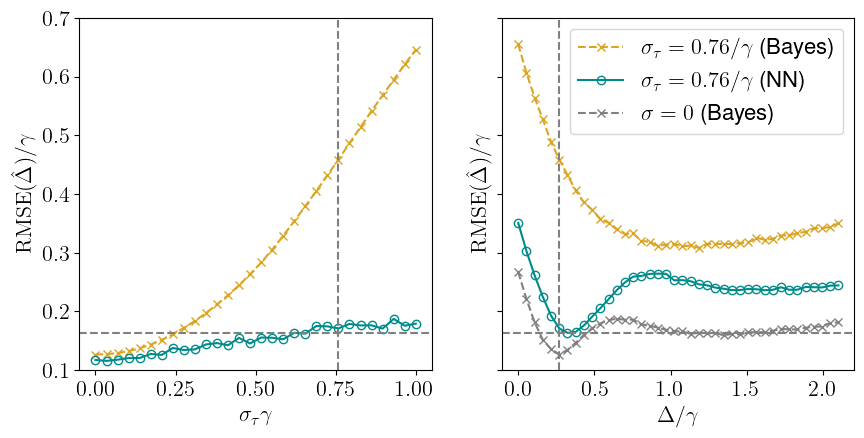

In [ ]:
fig, axis = plt.subplots(figsize=(10,10), ncols = 2, sharey = True)
idx = 1
idx_sigma = sigma_idx_list[1]
sigma_val = sigma_list[idx_sigma]

ax = axis[0]
ax.plot(sigma_list,rmse_sigma, 'x--',label= 'Bayes', color = "goldenrod")
ax.plot(sigma_list,rmse_sigma_NN,'o-', label= 'Neural Network', color = "darkcyan",  markerfacecolor='none')
ax.set_box_aspect(1)
ax.set_ylim(0.1,0.7)
ax.set_xlabel("$\\sigma_\\tau \\gamma$"); 
ax.set_ylabel("$\mathrm{RMSE}(\hat\Delta)/\\gamma$"); 
#ax.set_title('Jitter noise $\sigma_\\tau$')
ax.axvline(sigma_val, linestyle = "dashed", color = "gray")
ax.axhline(np.min(sqrt(MSE_noise_x_results)[idx][1]), linestyle = "dashed", color = "gray")


ax = axis[1]

ax.plot(deltalist, sqrt(MSE_noise_x_results)[idx][0], 'x--', color = "goldenrod", label = f"$\sigma_\\tau = {sigma_list[idx_sigma]:.2f}/\\gamma $ (Bayes)",
        markerfacecolor='none')
ax.plot(deltalist, sqrt(MSE_noise_x_results)[idx][1], 'o-', color = "darkcyan",
        markerfacecolor='none',  label = f"$\sigma_\\tau  = {sigma_list[idx_sigma]:.2f}/\gamma$ (NN)")

ax.plot(deltalist,sqrt(MSE_Bayes_Mean),'x--', label= '$\sigma = 0$ (Bayes)',  color = "gray", markerfacecolor='none')
ax.set_box_aspect(1)
ax.set_yticks([0., 0.1, 0.2, 0.3,0.4,0.5,0.6,0.7])
ax.set_ylim(0.1,0.7)

ax.legend(loc='upper right')
ax.set_xlabel("$\Delta/\gamma$")
ax.set_ylabel("$\mathrm{RMSE}(\hat\Delta)/\\gamma$"); 
ax.axvline(delta, linestyle = "dashed", color = "gray")
ax.axhline(np.min(sqrt(MSE_noise_x_results)[idx][1]), linestyle = "dashed", color = "gray")
plt.legend()
plt.savefig('figures/fig_5_a_b.pdf')
plt.savefig('figures/fig_5_a_b.svg')

plt.show()

### Noise in the y-train

- This evaluation requires a populated `data/models/1D/noise-y-train` folder. 

- This folder is populated by running the notebook `1-Training`

- The array of $\sigma$ considered here should match the one used to train the models in `data/models/1D/noise-y-train`

In [ ]:
sigma_min = 0.;sigma_max = 1.;nsigma = 30; sigma_list = np.linspace(0,sigma_max,nsigma)

In [ ]:
def compute_MSE_noise_ytrain(i_delta, nsets = 10000):
    "Compute the MSE VS sigma for a particular delta selected by the index i_delta "

    delta = deltalist[i_delta]
    trajectory_matrix = jumpsSetDelta[i_delta]

    # == Reference: MSE of the Bayesian prediction
    nsetsBayes = 10000
    estimate_array = np.array(
        parallel_map(get_estimates_Bayesian,trajectory_matrix[:nsetsBayes], task_kwargs=dict(nDeltaGrid=100, only_mean = True))
        )
    est_mean_anal = estimate_array
    mse_Bayes = np.mean((est_mean_anal - delta)**2)

    # == We loop over sigma, evaluating the predictions made with noise in the target data. 
    mse_sigma = []
    mse_sigma_NN = []
    varMSE_sigma_NN = []
    estimate_Calibration_Array = []
    estimate_NN_array = []

    seed = 1

    for sigma in sigma_list:
        noise = np.random.default_rng(seed).normal(0.,sigma,nsets)

        # This array is replicates the noise in the training. 
        estimate_array = delta + noise
        estimate_Calibration_Array.append(estimate_array)
        mse_mean = np.mean((estimate_array - delta)**2)
        mse_sigma.append(mse_mean)

        model=keras.models.load_model(datapath+f"models/1D/noise-y-train/model_best_Hist-sigma_{sigma}.hdf5", compile=False)
        estimate_array= np.asarray(model(trajectory_matrix)).flatten()
        estimate_NN_array.append(estimate_array)

        mse = np.mean((estimate_array - delta)**2)
        varMSE = np.var((estimate_array - delta)**2)
        mse_sigma_NN.append(mse)
        varMSE_sigma_NN.append(varMSE)

    mse_sigma = np.asarray(mse_sigma)
    mse_sigma_NN = np.asarray(mse_sigma_NN)
    estimate_NN_array = np.asarray(estimate_NN_array)
    estimate_Calibration_Array = np.asarray(estimate_Calibration_Array)
    varMSE_sigma_NN = np.asarray(varMSE_sigma_NN)

    return mse_Bayes, mse_sigma_NN, mse_sigma, varMSE_sigma_NN, estimate_NN_array

We make the estimation for all $\Delta$ and $\sigma$ values

In [ ]:
path_folder_cache = datapath+'results_cache/y_noise/'
path_cached_results_y_noise= path_folder_cache + 'results_MSE_ynoise.pkl'


if not os.path.isfile(path_cached_results_y_noise):
    print("No cached results found: Computing...")
    results_MSE_ynoise = [compute_MSE_noise_ytrain(i_delta) for i_delta in tqdm(range(deltalist.size))]

    # Save the results to a file using pickle
    create_directory(path_folder_cache)
    with open(path_cached_results_y_noise, 'wb') as file:
        pickle.dump(results_MSE_ynoise, file)
else:
    print("We found cached results: Loading.")
    # Load the results from the file in cache
    with open(path_cached_results_y_noise, 'rb') as file:
        results_MSE_ynoise = pickle.load(file)

In [ ]:
mse_Sigma_array = np.asarray([result[1] for result in results_MSE_ynoise])
mse_Bayes_array = np.asarray([result[0] for result in results_MSE_ynoise])
estimations_Sigma_array = np.asarray([result[4] for result in results_MSE_ynoise])

meanPred_Sigma_array = np.mean(estimations_Sigma_array, axis = 2).T

Plotting results

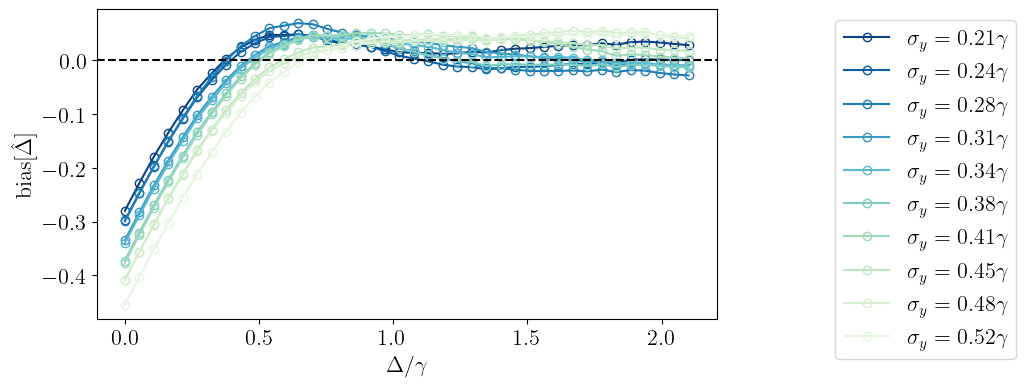

In [ ]:
# Create a colormap
cmap = matplotlib.colormaps["GnBu"].reversed()

fix, ax = plt.subplots(figsize=(8,8))

idx_initial = 6
idx_final = 16
step = 1
for idx_sigma in range(idx_initial,idx_final,step):
    # Use a different color from the colormap for each plot
    color = cmap((idx_sigma-idx_initial) / (idx_final-idx_initial))
    meanPredDelta_Fixed_Sigma = meanPred_Sigma_array[idx_sigma]

    ax.plot(deltalist, deltalist-meanPredDelta_Fixed_Sigma,  "o-", color = color, label = f"$\\sigma_y = {sigma_list[idx_sigma]:.2f}\gamma$",  markerfacecolor='none')


ax.axhline(0, linestyle = "dashed", color="black")

ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\mathrm{bias}[\hat\Delta]$")
ax.set_box_aspect(0.5)
#ax.set_ylim(0.008,0.4)
plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1))

plt.show()

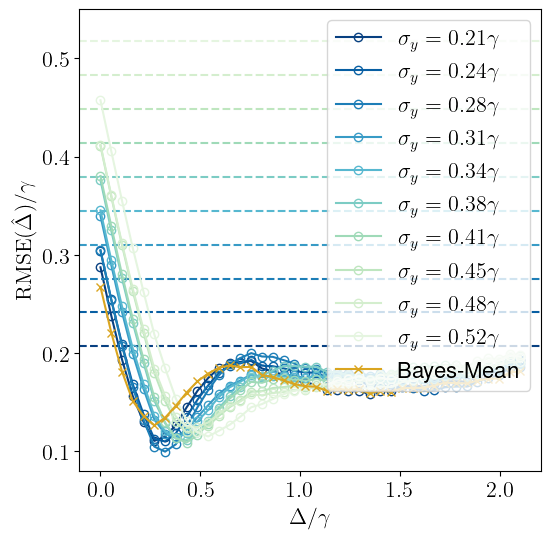

In [ ]:
# Create a colormap
cmap = matplotlib.colormaps["GnBu"].reversed()

fix, ax = plt.subplots(figsize=(6,6))

idx_initial = 6
idx_final = 16
step = 1
for idx_sigma in range(idx_initial,idx_final,step):
    # Use a different color from the colormap for each plot
    color = cmap((idx_sigma-idx_initial) / (idx_final-idx_initial))
    ax.plot(deltalist, sqrt(mse_Sigma_array[:,idx_sigma]),  "o-", color = color, label = f"$\\sigma_y = {sigma_list[idx_sigma]:.2f}\gamma$",  markerfacecolor='none')
    ax.axhline(sigma_list[idx_sigma], linestyle = "dashed", color=color)

#ax.plot(deltalist,sqrt(MSE_Class), 'D-',  label= "Classical", color = "crimson",markerfacecolor='none')
ax.plot(deltalist,sqrt(MSE_Bayes_Mean),'x-', label= 'Bayes-Mean',  color = "goldenrod", markerfacecolor='none')

ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{RMSE}(\hat\Delta)/\gamma$"),
ax.set_box_aspect(1)
ax.set_yticks([0., 0.1, 0.2, 0.3,0.4,0.5])
ax.set_ylim(0.08,0.55)
plt.legend(loc="upper right")

plt.show()

Fig.5 (c-d)

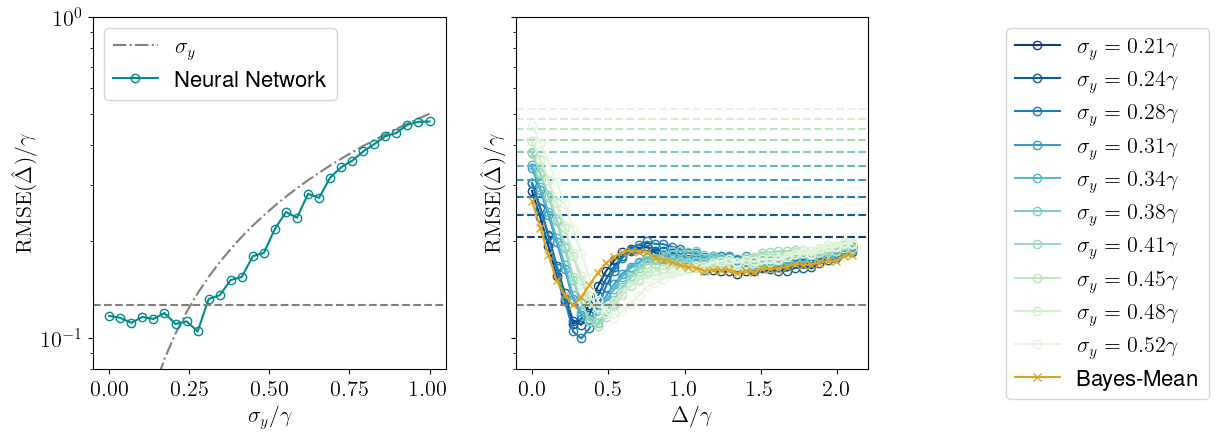

In [ ]:
fig, axis = plt.subplots(figsize=(10,10), ncols = 2, sharey = True)
idx = 1
idx_sigma = sigma_idx_list[1]
sigma_val = sigma_list[idx_sigma]

ax = axis[0]
i_select = 5
mse_sigma_NN = results_MSE_ynoise[i_select][1]
mse_Bayes = results_MSE_ynoise[i_select][0]

ax.plot(sigma_list, sigma_list, '-.',color='gray', label="$\sigma_y$")
ax.plot(sigma_list,sqrt(mse_sigma_NN),'o-', label= 'Neural Network', color = "darkcyan", markerfacecolor = "none")

ax.axhline(sqrt(mse_Bayes), color='gray', linestyle = "dashed")
ax.set_box_aspect(1)
ax.set_yticks([0.1, 0.5, 1])
ax.set_ylim(0.08,1)
ax.legend(loc='upper left')
ax.set_xlabel("$\sigma_y/\gamma$")
ax.set_ylabel("$\mathrm{RMSE}(\hat\Delta)/\\gamma$"); 
ax.set_yscale("log")



ax = axis[1]
idx_initial = 6
idx_final = 16
step = 1
for idx_sigma in range(idx_initial,idx_final,step):
    # Use a different color from the colormap for each plot
    color = cmap((idx_sigma-idx_initial) / (idx_final-idx_initial))
    ax.plot(deltalist, sqrt(mse_Sigma_array[:,idx_sigma]),  "o-", color = color, label = f"$\\sigma_y = {sigma_list[idx_sigma]:.2f}\gamma$",  markerfacecolor='none')
    ax.axhline(sigma_list[idx_sigma], linestyle = "dashed", color=color)
ax.axhline(sqrt(mse_Bayes), color='gray', linestyle = "dashed")

ax.plot(deltalist,sqrt(MSE_Bayes_Mean),'x-', label= 'Bayes-Mean',  color = "goldenrod", markerfacecolor='none')
ax.set_yscale("log")
ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{RMSE}(\hat\Delta)/\gamma$"),
ax.set_box_aspect(1)
ax.set_yticks([0.1, 0.5, 1])
ax.set_ylim(0.08,1)
plt.legend(loc="upper right",  bbox_to_anchor=(2, 1))
ax.set_yscale("log")



plt.savefig('figures/fig_5_c_d.pdf')
plt.savefig('figures/fig_5_c_d.svg')


plt.show()

## Supplemental Material

### Fig SM 1: RMSE for different choice of estimators built from Bayesian posteriors

#### Classical data

In [51]:
def calculate_Ptau_gaussian2D(tau, theta,gamma=1., N=48):
    Delta = theta[:,0]; Omega= theta[:,1]
    sigma = np.sqrt(((gamma**2 + 4*Delta**2)**2 - 8*(gamma**2 - 12*Delta**2)*Omega**2 + 64*Omega**4)/(N*gamma**2 * Omega**4))/4
    mu = (gamma**2 + 4*Delta**2 + 8*Omega**2)/(4*gamma*Omega**2)
    return np.exp(-0.5*((tau-mu)/sigma)**2)/(sigma*np.sqrt(2*np.pi))

def MMSE_MLE_estimator1D(tau, theta_list, return_prob = False):
    ''' 
    Returns estimator based on the mean of the posterior distribution (minimum mean square error (MMSE) estimator)
    '''
    # PT_Delta_list = np.asarray([calculate_PT(T,N,gamma,Omega, Delta) for Delta in Delta_list])
    PT_Delta_list = calculate_Ptau_gaussian2D(tau,theta_list)
    Delta_list = theta_list[:,0]

    norm = np.trapz(PT_Delta_list, Delta_list)
    #Posterior
    PDelta = PT_Delta_list/norm
    Delta_mean = np.trapz(PDelta*Delta_list,Delta_list)
    Delta_max = Delta_list[np.argmax(PDelta)]
    
    if return_prob==False:
        return Delta_mean, Delta_max
    else:
        return Delta_mean, Delta_max, PDelta

We compute estimators for a classical signal using the Bayesian framework and extract the following estimators:

- *Mean* of the posterior $\hat\theta = \int d\theta P(\theta|D)\theta$
- *Maximum* of the posterior $\hat\theta = \mathrm{argmax}_\theta P(\theta|D)$

In [ ]:
njumps = jumpsSetDelta.shape[2]
nsets =  10000

MSE_Class_Bayes_max = []
MSE_Class_Bayes_mean = []

Estimation_list_mean = []
Estimation_list_max = []

ndelta = len(deltalist)

ndeltaBayes = 200
Delta_bayes_list = np.linspace(0, 5., ndeltaBayes)
thetaList =  np.array([Delta_bayes_list, np.ones(ndeltaBayes)]).T

Omega = 1.

for i_delta in tqdm(range(ndelta)): # Loop over deltas
    
    delta=deltalist[i_delta]
    jumpsSet = jumpsSetDelta[i_delta]
    Delta_pred_mean = np.zeros(nsets,float)
    Delta_pred_max = np.zeros(nsets,float)

    # We sum over all the delays to get a list of final times
    tflist=np.sum(jumpsSet,axis =1)[:nsets] 
 
    for i in range(0,nsets): # Loop over sets
        tau = tflist[i]/48
        Delta_mean, Delta_max = MMSE_MLE_estimator1D(tau, thetaList)
        Delta_pred_mean[i] = Delta_mean
        Delta_pred_max[i] = Delta_max

    MSE_mean = np.mean((Delta_pred_mean-delta)**2)
    MSE_max = np.mean((Delta_pred_max-delta)**2)

    MSE_Class_Bayes_max.append(MSE_max)
    MSE_Class_Bayes_mean.append(MSE_mean)

    
    Estimation_list_mean.append(Delta_pred_mean)
    Estimation_list_max.append(Delta_pred_max)

In [ ]:
biasMean = np.asarray([np.mean(estimations - deltalist[idx]) for idx, estimations in enumerate(Estimation_list_mean)])
biasMAP = np.asarray([np.mean(estimations - deltalist[idx]) for idx, estimations in enumerate(Estimation_list_max)])
biasMeanQ = np.asarray([np.mean(estimations - deltalist[idx]) for idx, estimations in enumerate(estimationsBayes1D)])
biasMAPQ = np.asarray([np.mean(estimations - deltalist[idx]) for idx, estimations in enumerate(estimationsBayes1D_max)])

Now we compare different estimators extracted from the Bayesian posterior for the classical and the quantum signals.

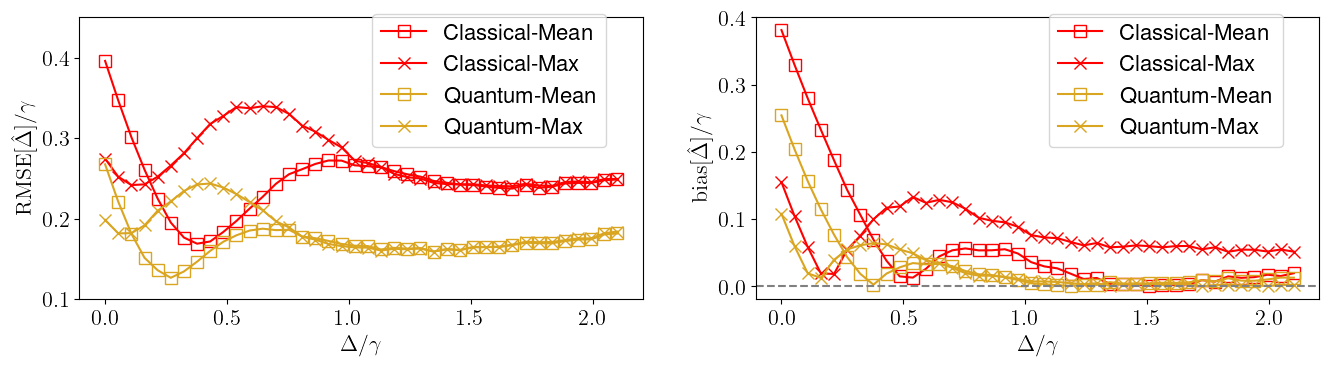

In [ ]:
fig, axis = plt.subplots(figsize=(16,8), ncols = 2)

ax = axis[0]
markersize = 8

ax.plot(deltalist,sqrt(MSE_Class_Bayes_mean), 's-',  label= "Classical-Mean", color = "red",markerfacecolor='none' , markersize = markersize)
ax.plot(deltalist,sqrt(MSE_Class_Bayes_max), 'x-',  label= "Classical-Max", color = "red",markerfacecolor='none', markersize = markersize)
ax.plot(deltalist,sqrt(MSE_Bayes_Mean),'s-', label= 'Quantum-Mean',  color = "goldenrod", markerfacecolor='none', markersize = markersize)
ax.plot(deltalist,sqrt(MSE_Bayes_Max),'x-', label= 'Quantum-Max',  color = "goldenrod", markerfacecolor='none', markersize = markersize)
ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{RMSE}[\hat\Delta]/\gamma$")
ax.set_box_aspect(0.5)
ax.set_yticks([0., 0.1, 0.2, 0.3,0.4])
ax.set_ylim(0.1,0.45)
ax.legend( bbox_to_anchor=(0.5, 1.05))

ax = axis[1]

ax.plot(deltalist,np.abs(biasMean), 's-',  label= "Classical-Mean", color = "red",markerfacecolor='none', markersize = markersize)
ax.plot(deltalist,np.abs(biasMAP), 'x-',  label= "Classical-Max", color = "red",markerfacecolor='none', markersize = markersize)
ax.plot(deltalist,np.abs(biasMeanQ),'s-', label= 'Quantum-Mean',  color = "goldenrod", markerfacecolor='none', markersize = markersize)
ax.plot(deltalist,np.abs(biasMAPQ),'x-', label= 'Quantum-Max',  color = "goldenrod", markerfacecolor='none', markersize = markersize)
ax.set_box_aspect(0.5)
ax.legend( bbox_to_anchor=(0.5, 1.05))
ax.axhline(0., linestyle = '--', color = 'gray')
ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{bias}(\hat\Delta]/\gamma$")

plt.savefig('figures/figSM1.pdf')
plt.savefig('figures/figSM1.svg')


plt.show()

### Fig SM2: Fisher information

#### Quantum Fisher information

Here we compute the Quantum Fisher information (QFI).
We follow the approach in [PRL 112, 170401 (2014)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.112.170401), where the expression for the QFI that we compute here can be found in Eq. (7).

In [52]:
def L_fun(omega, gamma, delta):
    'Returns Liouvillian for the two-level system model'
    return np.array([[0, 1j * omega, -1j * omega, gamma],
                    [1j * omega, -gamma/2 + 1j * delta, 0, -1j * omega],
                    [-1j * omega, 0, -gamma/2 - 1j * delta, 1j * omega],
                    [0, -1j * omega, 1j * omega, -gamma ]])


# Derivative of generalized Liouvillian with respect to theta_1
m1 = np.array([[0, 0, 0, 0],
               [0, 0, 0, 0],
               [0, 0, -1j, 0],
               [0, 0, 0, -1j]])

# Derivative of generalized Liouvillian with respect to theta_2
m2 = np.array([[0, 0, 0, 0],
               [0, 1j, 0, 0],
               [0, 0, 0, 0],
               [0, 0, 0, 1j]])

# Parameters
omega_sel = 1
gamma_sel = 1
delta_grid = deltalist

# Initialize derivatives list
der_list = []
identityVec = np.eye(2).flatten()

# Perform computation for each delta_sel
for delta_sel in delta_grid:
    umatrix = np.zeros((4,4), dtype = complex)

    Lsel = L_fun(omega_sel, gamma_sel, delta_sel)
    eigenvalues, eigenvectors = np.linalg.eig(Lsel)
    sorted_indices = np.argsort(eigenvalues.real)  # Sort eigenvalues in ascending order of real part
    eigenvalues = eigenvalues[sorted_indices]

    for i in range(4):
        umatrix[i] = eigenvectors[:, sorted_indices[i]]
    vmatrix = (np.linalg.inv(umatrix)).T

    # Normalized steady state
    rho_ss = umatrix[3] / (umatrix[3]@identityVec)
    sum1 = 0
    sum2 = 0
    for i in range(3):
        sum1 = sum1 + ((vmatrix[i] / eigenvalues[i]) @ m2 @ rho_ss) * umatrix[i]
        sum2 = sum2 + ((vmatrix[i] / eigenvalues[i]) @ m1 @ rho_ss) * umatrix[i]

    lambda_ij = (-m1@sum1 - m2@sum2)@ identityVec
    der_list.append(lambda_ij)  # Append the computed QFI

In [53]:
popGrid = np.asarray([compute_population_ss([omega_sel, delta]) for delta in delta_grid])
Tgrid = 48/popGrid
QFI_list = np.real(4*Tgrid*der_list)

#### Fisher information for Photon Counting

Direct application of the formula of the Cramer-Rao bound for unbiased estimators is not meaninful

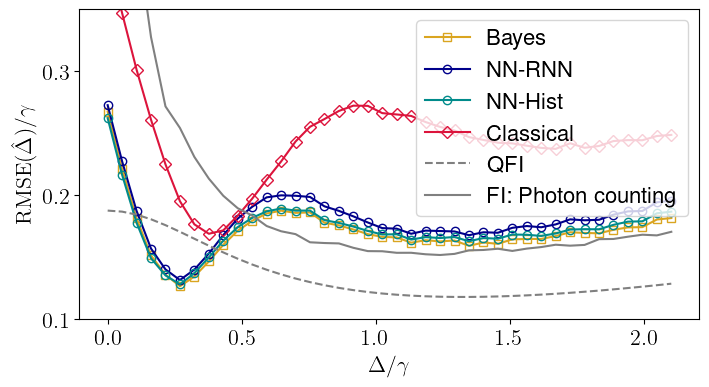

In [56]:
fix, ax = plt.subplots(figsize=(8,8))
ax.plot(deltalist,RMSE_Bayes_Mean,'s-', label= 'Bayes',  color = "goldenrod", markerfacecolor='none')
ax.plot(deltalist,RMSE_RNN,  'o-',label= 'NN-RNN' , color = "darkblue",markerfacecolor='none')
ax.plot(deltalist,RMSE_Hist, 'o-',  label= "NN-Hist",color = "darkcyan",markerfacecolor='none')
ax.plot(deltalist,RMSE_Class, 'D-',  label= "Classical", color = "crimson",markerfacecolor='none')
ax.plot(deltalist,sqrt(1/QFI_list), '--',  label= "QFI", color = "gray",markerfacecolor='none')
ax.plot(deltalist[1:],sqrt(1/FI_list[1:]), '-',  label= "FI: Photon counting", color = "gray",markerfacecolor='none')

ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{RMSE}(\hat\Delta)/\gamma$")
ax.set_box_aspect(0.5)
ax.set_yticks([0., 0.1, 0.2, 0.3])
ax.set_ylim(0.1,0.35)
ax.legend()
plt.savefig("figures/figSM2.pdf")
plt.savefig("figures/figSM2.svg")
plt.show()


#### Generalized Cramer Rao bound and Quantuum Cramer Rao bound

Direct application of the Cramer Rao bound in its usual form does not give consistent results. Since our estimators are *biased*, we need to use the generalized form

$$ \text{var}\,\hat\theta= \frac{[1 + \frac{db(\theta)}{d\theta}]^2}{F(\theta)} $$

In [57]:
biasClassical = meandeltaPred_Classical-deltalist
biasBayes = meandeltaPred_Bayes-deltalist
biasRNN = meandeltaPred_RNN-deltalist
biasHist = meandeltaPred_Hist-deltalist

# Compute derivatives of bias (we smooth data with Cubic Splines for this)

from scipy.interpolate import CubicSpline
from scipy import signal

def get_derivative(x,y):
    yfilt = signal.savgol_filter(y,7,3) 
    xFine = np.linspace(np.min(x), np.max(x), len(x))
    yfun = CubicSpline(x,yfilt)
    yFine= yfun(xFine)
    derYFine = np.gradient(yFine,xFine)
    derYfun = CubicSpline(xFine,derYFine)
    derY = derYfun(x)
    return derY


derBiasClassical = get_derivative(deltalist,biasClassical)
derBiasBayes = get_derivative(deltalist,biasBayes)
derBiasRNN =  get_derivative(deltalist,biasRNN)
derBiasHist =   get_derivative(deltalist,biasHist)

From the derivatives, we can now define the generalized Cramer Rao bounds (Fisher information) and quantum Cramer Rao bounds (Quantum Fisher information).

In [58]:
CRB_Class = sqrt( (1 + derBiasClassical)**2/FI_list_classical)
CRB_Bayes = sqrt( (1 + derBiasBayes)**2/FI_list)
QCRB_Bayes = sqrt( (1 + derBiasBayes)**2/QFI_list)


In [ ]:
fix, ax = plt.subplots(figsize=(8,8))

ax.plot(deltalist,RMSE_Class, 'D-',  label= "Classical", color = "crimson",markerfacecolor='none')
ax.plot(deltalist,CRB_Class, '--',  label= "CRB Classical", color = "crimson",markerfacecolor='none')

ax.plot(deltalist,RMSE_Bayes_Mean,'s-', label= 'Quantum (Bayes)',  color = "goldenrod", markerfacecolor='none')
ax.plot(deltalist,CRB_Bayes,'--', label= 'CRB Quantum (Bayes)',  color = "goldenrod", markerfacecolor='none')
ax.plot(deltalist,QCRB_Bayes,'--x', label= 'QCRB Quantum (Bayes)',  color = "goldenrod", markerfacecolor='none')
ax.plot(deltalist,RMSE_RNN,  'o-',label= 'NN-RNN' , color = "darkblue",markerfacecolor='none')
ax.plot(deltalist,RMSE_Hist, 'o-',  label= "NN-Hist",color = "darkcyan",markerfacecolor='none')


ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{RMSE}(\hat\Delta)/\gamma$")
plt.legend(loc="upper right", bbox_to_anchor=(1, 1.5))

ax.set_box_aspect(0.5)
ax.set_yticks([0., 0.1, 0.2, 0.3])

plt.savefig("figures/figSM2.pdf")
plt.savefig("figures/figSM2.svg")
plt.show()

### Fig SM 3: Turning model Hist-Dense into TensorFlow Lite model

Here, we demonstrate the process of reducing our trained Hist-Dense model into a [TensorFlow Lite (TFLite)](https://www.tensorflow.org/lite) model. 
This step holds significant importance in the realm of deploying machine learning models, especially on resource-constrained devices like mobile phones and embedded systems. 

TensorFlow Lite is a lightweight and optimized version of TensorFlow specifically designed for edge and mobile devices. By converting a model into TFLite format, we can achieve several advantages. First, TFLite models are more memory-efficient and have a smaller footprint, making them suitable for deployment on devices with limited resources. Second, TFLite models often exhibit faster inference times, crucial for real-time applications. Additionally, TFLite models are compatible with TensorFlow Lite Interpreter, which allows seamless integration with various platforms.



In [62]:
tflite_dir = datapath + 'models/1D/TFLite/'
create_directory(tflite_dir)
TFLITE_MODEL = tflite_dir+"modelHist.tflite"

Folder already exists.


In [ ]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : modelHist(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(modelHist.inputs[0].shape, modelHist.inputs[0].dtype)
)

# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open(TFLITE_MODEL, "wb").write(tflite_quant_model)

#### Load TFLite model

In [64]:
# Load TFLite model and see some details about input/output
tflite_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

# Resize so that I can run inference on larger batches of data
tflite_interpreter.resize_tensor_input(input_details[0]['index'], (nsets, 48))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (nsets, 48))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


#### Make predictions

In [65]:
def predictor_tflite(trajectory_matrix):
    # Set batch of data into input tensor
    tflite_interpreter.set_tensor(input_details[0]['index'], np.float32(trajectory_matrix))
    # Run inference
    tflite_interpreter.invoke()
    # Get prediction results
    Delta_pred = tflite_interpreter.get_tensor(output_details[0]['index'])
    return Delta_pred

In [ ]:
MSE_TFLite = benchmark_predictor(predictor_tflite)[0]

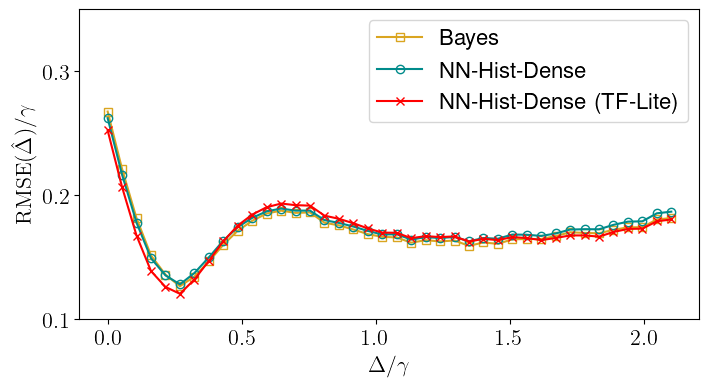

In [69]:
fix, ax = plt.subplots(figsize=(8,8))
ax.plot(deltalist,sqrt(MSE_Bayes_Mean),'s-', label= 'Bayes',  color = "goldenrod", markerfacecolor='none')
ax.plot(deltalist,sqrt(MSE_Hist), 'o-',  label= "NN-Hist-Dense",color = "darkcyan",markerfacecolor='none')
ax.plot(deltalist,sqrt(MSE_TFLite), 'x-',  label= "NN-Hist-Dense (TF-Lite)",color = "red",markerfacecolor='none')


ax.set_xlabel("$\Delta/\gamma$"), ax.set_ylabel("$\\mathrm{RMSE}(\hat\Delta)/\gamma$")
ax.set_box_aspect(0.5)
ax.set_yticks([0., 0.1, 0.2, 0.3])
ax.set_ylim(0.1,0.35)
ax.legend()
plt.savefig('figures/figSM3.pdf')
plt.savefig('figures/figSM3.svg')
plt.show()